In [2]:
import nibabel as nib
import numpy as np
from pathlib import Path
from nilearn import image as nimg
from nilearn import surface as nsurf
from nilearn import plotting as nplot
from nilearn.mass_univariate import permuted_ols
from matplotlib import pyplot as plt
from nilearn import datasets as ndata
from nilearn.glm import cluster_level_inference
from nilearn.regions import connected_regions
import seaborn as sns
from tqdm import tqdm
import pandas as pd
mni = ndata.load_mni152_template(resolution=1.0)
fsaverage = ndata.fetch_surf_fsaverage('fsaverage')


def mask_labels(atlas, labels:list[int]):
    mask_output = np.zeros(atlas.shape)
    for label in labels:
        partial_mask = nimg.math_img(f'atlas == {label}', atlas=atlas).get_fdata()
        mask_output = np.logical_or(mask_output, partial_mask)
    return nib.Nifti1Image(mask_output.astype(float), atlas.affine)

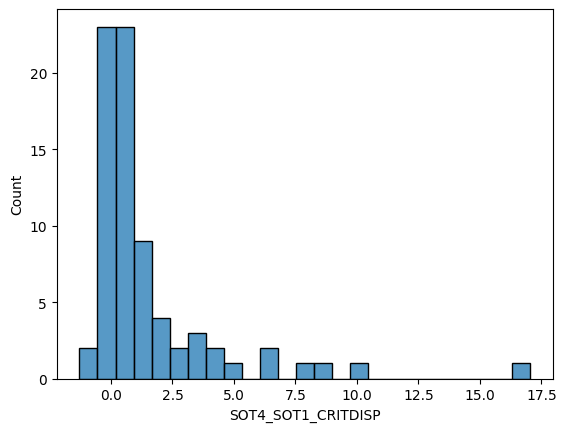

In [3]:
df_ppg = pd.read_csv('data/PPG_FOG_NEUROCOM_FINAL_v2.csv', index_col=0)
df_cop = pd.read_csv('data/all_cop_measures.csv', index_col=0).loc[df_ppg.index]
critdisp_sot4 = df_cop.query('vision == "OPEN" and prop == "SWAY" and has_fog in [0, 1]').critical_displacement_Diffusion_AP
critdisp_sot1 = df_cop.query('vision == "OPEN" and prop == "FIXED" and has_fog in [0, 1]').critical_displacement_Diffusion_AP
critdisp_delta = critdisp_sot4 - critdisp_sot1
df_ncom = pd.DataFrame({'SOT4_SOT1_CRITDISP': critdisp_delta})
sns.histplot(df_ncom.SOT4_SOT1_CRITDISP)
plt.show()

{0: 'Background',
 1: 'Left Cerebral White Matter',
 2: 'Left Cerebral Cortex ',
 3: 'Left Lateral Ventrical',
 4: 'Left Thalamus',
 5: 'Left Caudate',
 6: 'Left Putamen',
 7: 'Left Pallidum',
 8: 'Brain-Stem',
 9: 'Left Hippocampus',
 10: 'Left Amygdala',
 11: 'Left Accumbens',
 12: 'Right Cerebral White Matter',
 13: 'Right Cerebral Cortex ',
 14: 'Right Lateral Ventricle',
 15: 'Right Thalamus',
 16: 'Right Caudate',
 17: 'Right Putamen',
 18: 'Right Pallidum',
 19: 'Right Hippocampus',
 20: 'Right Amygdala',
 21: 'Right Accumbens'}

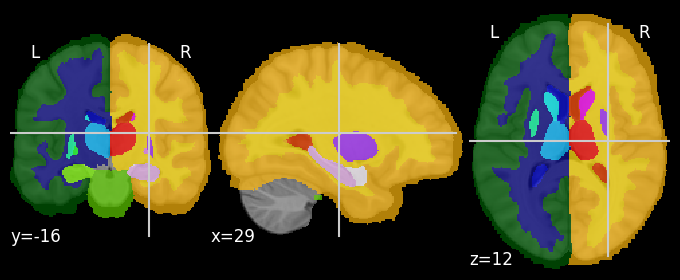

In [4]:
cort_atlas = ndata.fetch_atlas_harvard_oxford('cort-maxprob-thr0-1mm')
atlas = ndata.fetch_atlas_harvard_oxford('sub-maxprob-thr0-1mm')
nplot.plot_roi(atlas['maps'], bg_img=mni)
subcortical_atlas_labels = dict(enumerate(atlas['labels']))
subcortical_atlas_labels

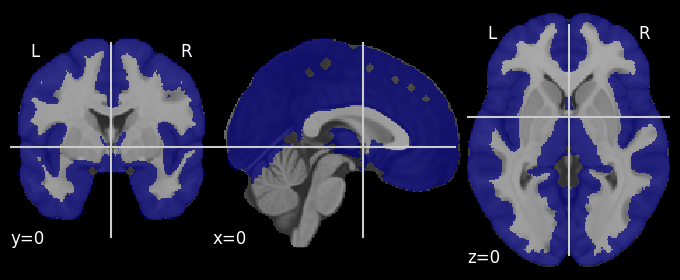

In [ ]:
subcortical_roi = [2, 13, 4, 9, 10, 15, 19, 20]
pmp_mask = mask_labels(atlas['maps'], subcortical_roi)
gm_mask = ndata.fetch_icbm152_brain_gm_mask()
gm_mask = nimg.resample_to_img(gm_mask, pmp_mask)
pmp_mask_gm = nimg.math_img('mask * gm', mask=pmp_mask, gm=gm_mask)
nplot.plot_roi(pmp_mask_gm, bg_img=mni, cut_coords=(0,0,0))
plt.show()

In [ ]:
k3_template = 'data/pmp/k3/PMP_{}_R_KLLS_pmpk3_mni.nii.gz'
pmpk3_paths = {}
for subjid in df_ncom.index:
    imgpath = Path(k3_template.format(subjid))
    if imgpath.exists():
        pmpk3_paths[subjid] = imgpath
    else:
        print(imgpath)
df_k3 = df_ncom.join(df_ppg[['has_fog']]).filter(items=pmpk3_paths.keys(), axis=0)
df_k3.groupby('has_fog').describe().T

has_fog                           0          1
SOT4_SOT1_CRITDISP count  59.000000  16.000000
                   mean    0.877425   3.874649
                   std     1.532051   4.819000
                   min    -1.281173  -0.044307
                   25%     0.007561   0.511132
                   50%     0.375408   1.307512
                   75%     1.426748   6.582686
                   max     8.676911  17.048833

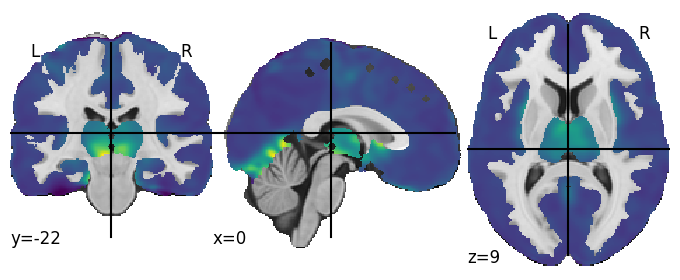

In [7]:
img = nib.load(pmpk3_paths['PPG-PAT003'])
pmp_mask_gm = nimg.resample_to_img(pmp_mask_gm, img, interpolation='nearest')
atlas_img = nimg.resample_to_img(atlas['maps'], img, interpolation='nearest')
img = nimg.math_img('img * mask', img=img, mask=pmp_mask_gm)
nplot.plot_img(img, bg_img=mni, threshold='auto')
plt.show()

## K3

In [8]:
pmpk3_voxels = {}
errors = []
for subj, imgpath in tqdm(list(pmpk3_paths.items())):
    try:
        img = nib.load(imgpath)
    except Exception as e:
        errors.append(e)
        continue
    pmpk3_voxels[subj] = img.get_fdata()[pmp_mask_gm.get_fdata().astype(bool)]
df_pmpk3_voxels = pd.DataFrame(pmpk3_voxels).T
print(errors)
print(df_pmpk3_voxels.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:07<00:00, 10.42it/s]


[]
(75, 1104292)


In [10]:
df_cop_k3_reg = df_ncom[['SOT4_SOT1_CRITDISP']].join(df_pmpk3_voxels, how='inner')
result_k3 = permuted_ols(
    df_cop_k3_reg[['SOT4_SOT1_CRITDISP']].astype(float).to_numpy(),
    df_cop_k3_reg.iloc[:,1:].to_numpy(),
    n_perm=1,
    output_type='dict'
)
result_k3.keys()

/Users/stivenr/Dropbox (University of Michigan)/PPG_FOG_NEUROCOM/envs/Stivens-MacBook-Pro.local.env/lib/python3.10/site-packages/nilearn/mass_univariate/permuted_least_squares.py:812: UserWarning: The specified number of permutations is 1 and the number of jobs to be performed in parallel has set to 1. This is incompatible so only 1 jobs will be running. You may want to perform more permutations in order to take the most of the available computing resources.
  warnings.warn(


dict_keys(['t', 'logp_max_t', 'h0_max_t'])

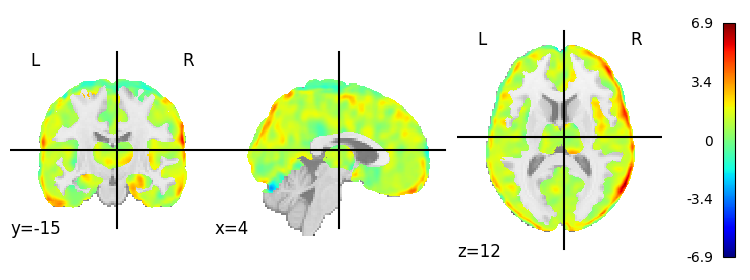

In [13]:
stat_k3_img = np.zeros(pmp_mask_gm.shape)
stat_k3_img[pmp_mask_gm.get_fdata().astype(bool)] = result_k3['t'].flatten()
stat_k3_img = nib.Nifti1Image(stat_k3_img, pmp_mask_gm.affine)
nplot.plot_stat_map(stat_k3_img, cmap='jet')
ba_atlas = nib.load('atlases/AtlasCollection/Brodmann/Brodmann.nii.gz').slicer[:,:,:,0]
cort_atlas_pmp = nimg.resample_to_img(ba_atlas, stat_k3_img, interpolation='nearest')

In [14]:
labels = pd.read_csv('data/labels.txt').set_index('label')
labels = labels.assign(
    region = labels.region.apply(str.strip)
)
label_dict = labels.to_dict()['region']
pd.Series(label_dict)

1000    ctx-lh-unknown
1001      ctx-lh-BA1_3
1002        ctx-lh-BA2
1003        ctx-lh-BA4
1004        ctx-lh-BA5
             ...      
2035       ctx-rh-BA43
2036       ctx-rh-BA44
2037       ctx-rh-BA45
2038       ctx-rh-BA46
2039       ctx-rh-BA47
Length: 80, dtype: object

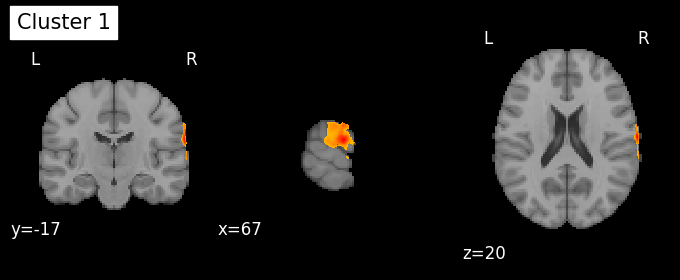

ctx-rh-BA40     483
ctx-rh-BA22     318
ctx-rh-BA2      296
ctx-rh-BA1_3    169
dtype: int64 



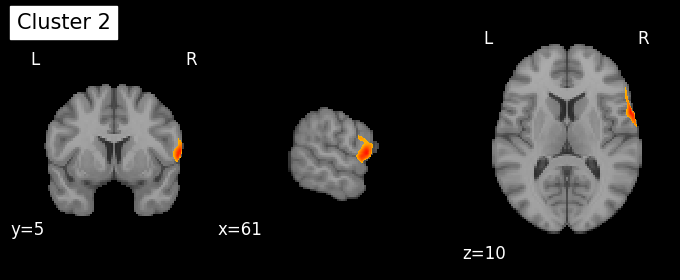

ctx-rh-BA44     414
ctx-rh-BA6      315
ctx-rh-BA1_3    245
ctx-rh-BA2      115
ctx-rh-BA4       79
ctx-rh-BA45      60
ctx-rh-BA22      47
dtype: int64 



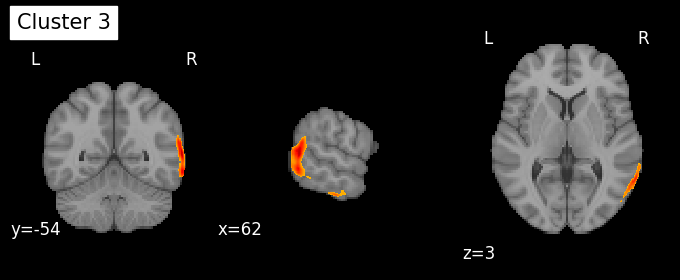

ctx-rh-BA21    1980
ctx-rh-BA37    1053
ctx-rh-BA39     495
ctx-rh-BA22     470
ctx-rh-BA20     196
ctx-rh-BA19      11
ctx-rh-BA40       1
dtype: int64 



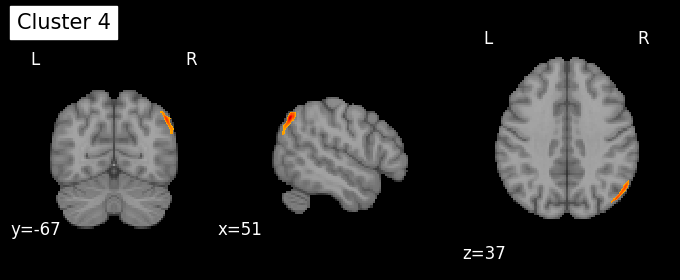

ctx-rh-BA39    605
ctx-rh-BA40     27
ctx-rh-BA19     19
dtype: int64 



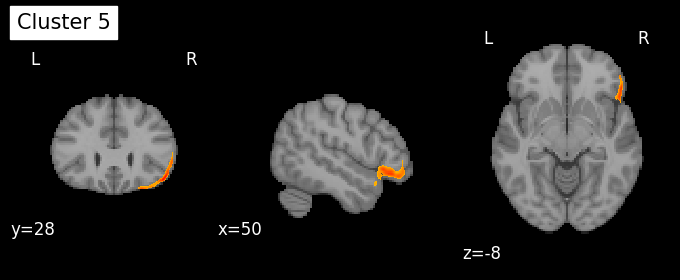

ctx-rh-BA47    1353
ctx-rh-BA45     561
ctx-rh-BA22     157
ctx-rh-BA44      32
ctx-rh-BA38      29
ctx-rh-BA46      17
dtype: int64 



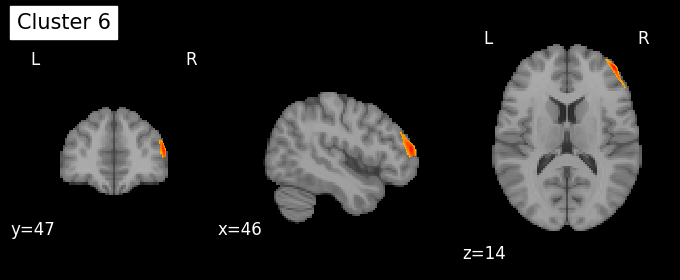

ctx-rh-BA46    447
ctx-rh-BA10    360
ctx-rh-BA45    149
ctx-rh-BA9      36
dtype: int64 



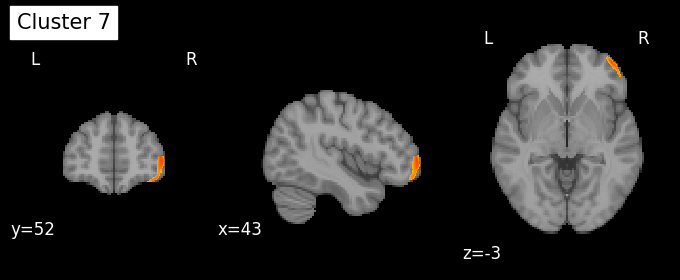

ctx-rh-BA10    814
ctx-rh-BA47    253
ctx-rh-BA46    201
ctx-rh-BA45      5
dtype: int64 



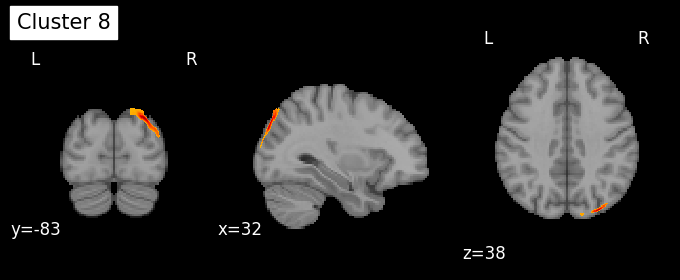

ctx-rh-BA19    522
ctx-rh-BA7     502
ctx-rh-BA39    334
ctx-rh-BA18     45
dtype: int64 



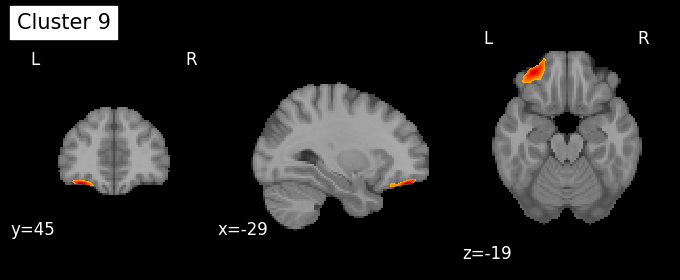

ctx-lh-BA47    884
ctx-lh-BA10     37
ctx-lh-BA11      9
dtype: int64 



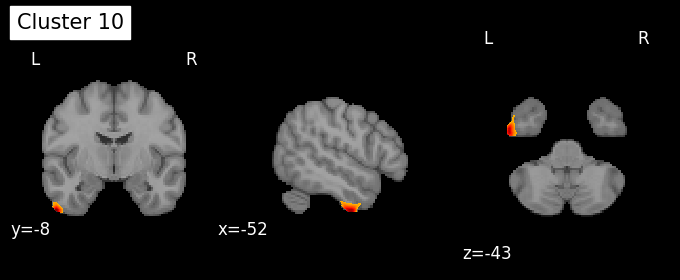

ctx-lh-BA20    488
ctx-lh-BA38     86
ctx-lh-BA21     30
dtype: int64 



In [17]:
stat_k3_img_corrected = cluster_level_inference(stat_k3_img, mask_img=pmp_mask_gm)
stat_k3_img_components, ids = connected_regions(stat_k3_img_corrected, min_region_size=1000)

n = 0

dict_table = {
    'region': [],
    'nvox': [],
    'maxt': []
}

stat_imgs = []

for _ in ids:
    n += 1
    comp_img = stat_k3_img_components.slicer[:,:,:,n-1]
    stat_img = nimg.math_img('stat * (comp > 0)', stat=stat_k3_img, comp=comp_img)
    stat_imgs.append(stat_img)
    atlas_img = nimg.math_img('atlas * (comp > 0)', atlas=cort_atlas_pmp, comp=comp_img)
    dict_table['maxt'].append(stat_img.get_fdata().max())
    vec_labels = pd.Series(atlas_img.get_fdata().flatten()).value_counts().drop(0.0).rename(int).rename(label_dict)
    regions = ', '.join(vec_labels.index)
    dict_table['region'].append(regions)
    dict_table['nvox'].append((abs(comp_img.get_fdata().flatten()) > 0).sum())
    nplot.plot_stat_map(
        stat_img,
        title='Cluster '+str(n),
        black_bg=True,
        vmax=7,
        colorbar=False,
        draw_cross=False,
        cmap='jet'
    )
    plt.show()
    print(vec_labels, '\n')

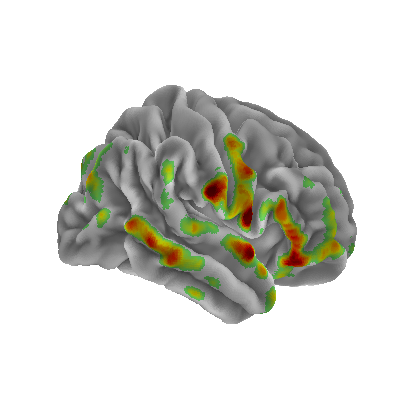

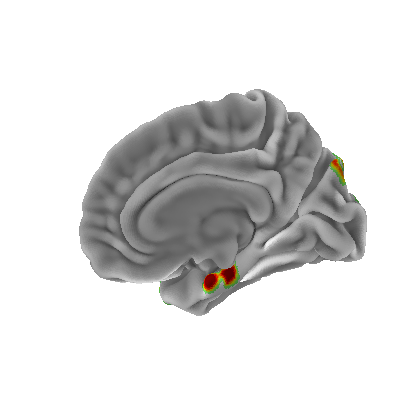

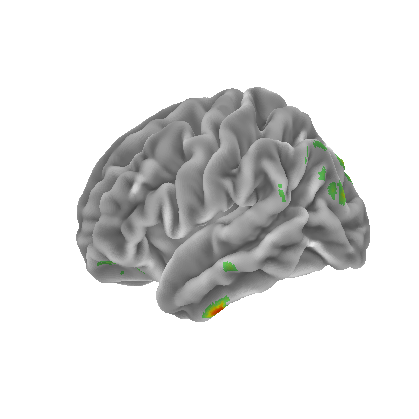

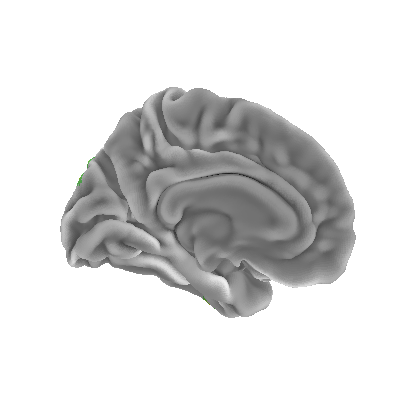

In [19]:
stat_k3_img_corrected_t = nimg.math_img('t * (cor > 0)', cor=stat_k3_img_corrected, t=stat_k3_img)

for side in ['right', 'left']:
    tst = nsurf.vol_to_surf(
        stat_k3_img_corrected_t,
        fsaverage[f'pial_{side}'],
        inner_mesh=fsaverage[f'white_{side}']
    )
    for view in ['lateral', 'medial']:
        nplot.plot_surf_stat_map(
            fsaverage[f'pial_{side}'],
            stat_map=tst,
            bg_map=fsaverage[f'curv_{side}'],
            bg_on_data=True,
            hemi=side,
            view=view,
            colorbar=False,
            cmap='jet',
            threshold=1e-3,
            vmax=3.5
        )
        plt.show()

In [20]:
df_vox = pd.DataFrame(dict_table)

df_vox = df_vox.assign(
    Cluster = [i+1 for i in df_vox.index],
    maxt = df_vox.maxt.round(2),
    region = df_vox.region.apply(lambda label: ', '.join(label.split(', ')[:4]))
).set_index('Cluster').rename({
    'region': 'Brodmann areas',
    'nvox': 'Number of voxels',
    'maxt': 'Maximal T-value'
}, axis=1)

df_vox

,Brodmann areas,Number of voxels,Maximal T-value
Cluster,,,
1,"ctx-rh-BA40, ctx-rh-BA22, ctx-rh-BA2, ctx-rh-B...",2081,5.66
2,"ctx-rh-BA44, ctx-rh-BA6, ctx-rh-BA1_3, ctx-rh-BA2",2043,5.61
3,"ctx-rh-BA21, ctx-rh-BA37, ctx-rh-BA39, ctx-rh-...",7018,6.44
4,"ctx-rh-BA39, ctx-rh-BA40, ctx-rh-BA19",1567,6.05
5,"ctx-rh-BA47, ctx-rh-BA45, ctx-rh-BA22, ctx-rh-...",3209,5.66
6,"ctx-rh-BA46, ctx-rh-BA10, ctx-rh-BA45, ctx-rh-BA9",1592,5.40
7,"ctx-rh-BA10, ctx-rh-BA47, ctx-rh-BA46, ctx-rh-...",1740,4.85
8,"ctx-rh-BA19, ctx-rh-BA7, ctx-rh-BA39, ctx-rh-BA18",2313,6.51
9,"ctx-lh-BA47, ctx-lh-BA10, ctx-lh-BA11",1406,6.26
